## Here we will build a multi step agentic rag using langgraph. 


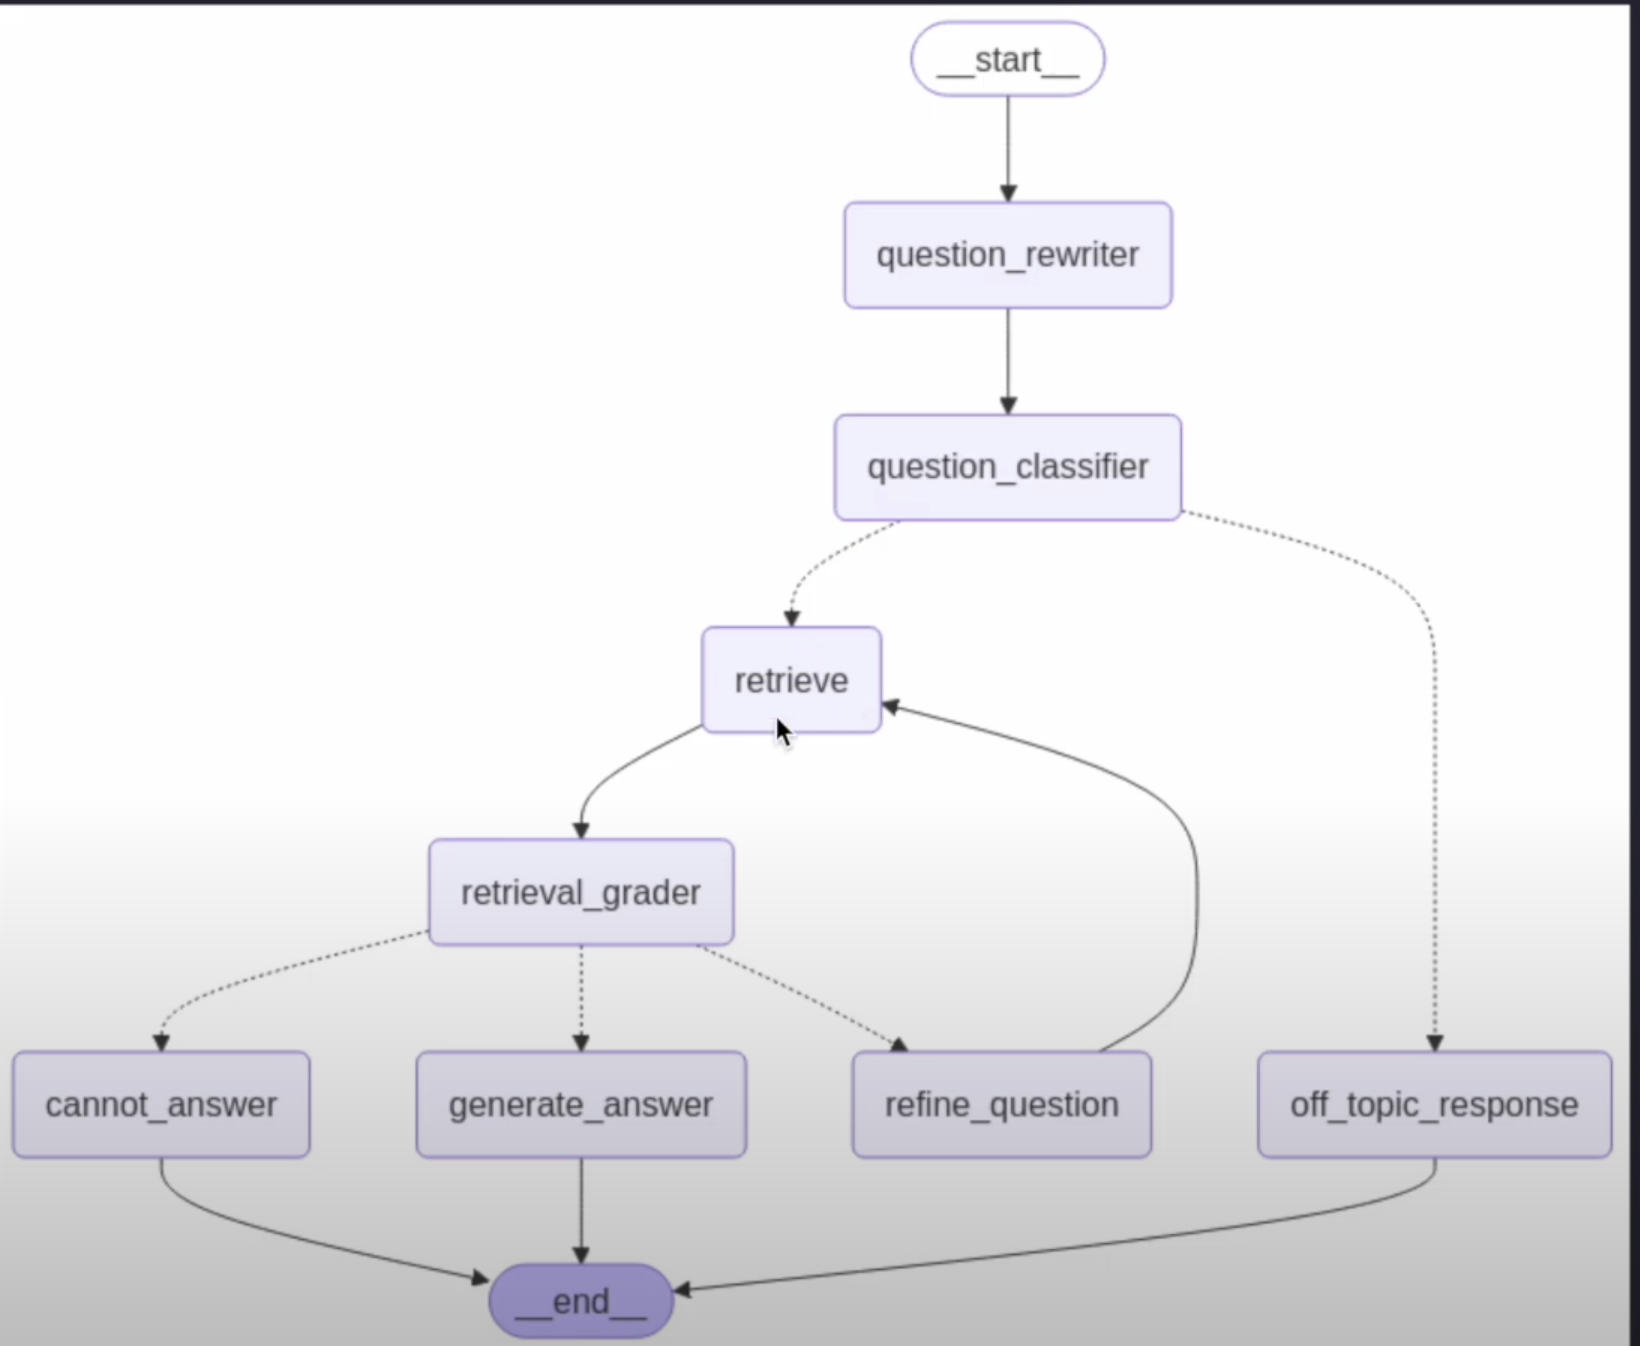

In [ ]:
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_community.vectorstores import Chroma 
from langchain.schema import Document
from langchain_core.prompts import ChatPromptTemplate

from typing import List,TypedDict,Literal
from langchain_core.messages import AIMessage,BaseMessage,HumanMessage,SystemMessage
from pydantic import BaseModel,Field

from langgraph.graph import StateGraph,END

from langgraph.checkpoint.memory import MemorySaver

### Creating index and retriever

In [ ]:
#taking some list of documents for our index,
docs=[
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source":"about.txt"}
        ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source":"hours.txt"}
        ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source":"membership.txt"}
        ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source":"classes.txt"}
        ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source":"trainers.txt"}
        ), 
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source":"facilities.txt"}
        )
     ]

In [ ]:
#defining embedding model
OPENAI_API_KEY = ""
embedding_model="text-embedding-3-small"

embedding=OpenAIEmbeddings(model=embedding_model,api_key=OPENAI_API_KEY)

In [ ]:
#defining vector index
vector_index=Chroma.from_documents(docs,embedding=embedding)

In [ ]:
#defining retriever
retriever=vector_index.as_retriever(search_type="similarity",search_kwargs={"k": 2})

In [ ]:
#just testing the retriever
retriever.invoke("when was peak performance gym founded")

[Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.'),
 Document(metadata={'source': 'trainers.txt'}, page_content='Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).')]

### building graph

In [ ]:
OPENAI_API_KEY = ""


In [ ]:
# we will build the class for state for this graph , this state will be valid for full graph until interrupted/exited/new question asked.
class AgentState(TypedDict):
    question:HumanMessage
    messages:List[BaseMessage]
    documents:List[Document]
    on_topic:str
    rephrased_question:str
    proceed_to_generate:bool
    refine_count:int
    

In [ ]:
#defining the graph
#StateGraph: The StateGraph class is the main graph class to use , it is a graph whose nodes communicate by reading and writing to a shared state.

workflow=StateGraph(state_schema=AgentState)

In [ ]:
#here we will build node for question rewriter which is required to make a new query based on history
#we need to reset state variables except question and messages since for each new question, graph runs from starting.
#we will maintain history using memory(checkpoint) variable and not with other state variables
def query_rewriting(state : AgentState):
    print("entered query_rewriting")
    state["documents"]=[]
    state["on_topic"]=""
    state["rephrased_question"]=""
    state["proceed_to_generate"]=False
    state["refine_count"]=0
    
    if "messages" not in state or state["messages"] is None:          #first time chat
        state["messages"]=[]
        
    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])
    
    if len(state["messages"])>1:
        previous_conversations=state["messages"][:-1]        #except last, last message is user question
        current_question=state["question"].content
        
        prompt=[]
        rephrase_prompt=SystemMessage(content="You are an helpful assistant that rephrases user's query to be a standalone question optimzed for retrieval")
        prompt.append(rephrase_prompt)
        prompt.extent(previous_conversations)
        prompt.append(HumanMessage(content=current_question))
        
        rephrase_template=ChatPromptTemplate.from_messages(prompt)
        llm=ChatOpenAI(model="gpt-4o",api_key=OPENAI_API_KEY)
        rephrase_template=rephrase_template.format()
        response=llm.invoke(rephrase_template)
        respone=response.content.strip()
        print(f"rephrased question : {respone}")
        state["rephrased_question"]=respone
        
    else:
        state["rephrased_question"]=state["question"].content
        
    return state
        


In [ ]:
# here we will build a node for question classifier whehter it is related to index's topic of out of topic question
#here i am using pydantic to get structured data from llm for this node
# class topic(BaseModel):
#     is_topic : Literal["Yes","No"] =Field(description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'")
  
class topic(BaseModel):
    is_topic: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )
def classifier(state : AgentState):
    print("entered classifier")

    system_message = SystemMessage(
        content=""" You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    7. Anything else about Peak Performance Gym
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    )
    
    human_message=HumanMessage(content=f"User Question : {state['rephrased_question']}")
    template=ChatPromptTemplate.from_messages([system_message,human_message])
    structured_llm=ChatOpenAI(model="gpt-4o",api_key=OPENAI_API_KEY).with_structured_output(topic)
    topic_chain=template | structured_llm
    result=topic_chain.invoke({})
    state["on_topic"]=result.is_topic.strip()      #with_structured_output gives output as pydantic object  , so we are getting output like result.field_name
    
    print(f"question_classifier: on_topic = {state['on_topic']}")
    
    return state
    
    
    

In [ ]:
#now we will build out router function that routes based on the topic to either retrieve or off topic response node.
#basically in conditional edge we give this as the function

def router(state:AgentState):
    if state["on_topic"]=="Yes":
        return "retriever_node"
    else :
        return "out_of_topic"
    

In [ ]:
#here we will build retriever node which just retrieves from the vector store based on rephrased_question
def retriever_node(state : AgentState):
    print("entered retriever_node")
    retrieived_docs=retriever.invoke(state["rephrased_question"])
    state["documents"]=retrieived_docs
    print(f"retrieved documents length : {len(retrieived_docs)}")
    return state

In [ ]:
#node for retrival grader which checks whther the retrieved docs are related to query,
#if atleast one doc is relevant we will go and generate answer (in different node)

class grader(BaseModel):
    relevant: Literal["Yes","No"] = Field(description="Document is relevant to the question? If yes -> Yes , if not -> No")
    
def retrieval_grader(state: AgentState):
    print("entered retrieval_grader")
    documents_retrieved=state["documents"]
    question=state["rephrased_question"]
    system_message=SystemMessage(
        content="""You are a grader accessing the relevancy of the retrieved document to a user question.
        If the document contains information relevant to the user's question answer as Yes otherwise as No.
        """)
    structured_llm=ChatOpenAI(model="gpt-4o",api_key=OPENAI_API_KEY).with_structured_output(grader)
    
    relevant_docs=[]
    for doc in documents_retrieved:
        human_message=HumanMessage(content=f"User Question : {question} \n\n Document Retrieved :\n {doc.page_content}")

        template=ChatPromptTemplate.from_messages([system_message,human_message])
        chain=template | structured_llm
        result=chain.invoke({})
        is_relevant=result.relevant.strip()
        if is_relevant=="Yes":
            relevant_docs.append(doc)
    
    state["documents"]=relevant_docs
    
    state["proceed_to_generate"]= len(relevant_docs) > 0      #if atleast one relevant doc then proceed to generate
    
    return state
        

In [ ]:
#now after this node we want a router that routes to either of 3 nodes based on conditions

def generate_router(state: AgentState):
    print("entered generate_router")

    proceed_to_generate=state["proceed_to_generate"]
    refine_count=state["refine_count"]
    if proceed_to_generate:
        return "generate_answer"
    elif refine_count>2:         #we will do refine question only 2 time, if still no relevant doc, then go to can not answer node
        return "cannot_answer"
    else:
        return "refine_question"
        

In [ ]:
#node if relevant docs are not there to generate answer
def cannot_answer(state: AgentState):
    print("entered cannot_answer")

    static_reply=AIMessage(content="I am sorry, I am not able to find the information you are looking for.")
    state["messages"].append(static_reply)
    return state
    

In [ ]:
#off topic node which will be called if question is out of topic than the index

def out_of_topic(state : AgentState):
    print("entered out_of_topic")

    static_reply=AIMessage(content="I am sorry, I cant answer this question, please ask questions only about out gym.")
    state["messages"].append(static_reply)
    return state
    

In [ ]:
# node to refine the question if no relevant documents are retrieved
def refine_question(state: AgentState):
    print("entered refine_question")

    rephrased_question=state["rephrased_question"]
    refine_count=state["refine_count"]
    system_message=SystemMessage(
        content="""You are a helpful Assistant that slighly refines the user's question to improve retrieved results.
        Provide a slightly adjusted version of the question.       
        """)
    human_message=HumanMessage(content=f"Original User Question :\n {rephrased_question} " )
    template=ChatPromptTemplate.from_messages([system_message,human_message])
    prompt=template.format()
    llm=ChatOpenAI(model="gpt-4o",api_key=OPENAI_API_KEY)
    result=llm.invoke(prompt)
    refined_question=result.content.strip()
    state["rephrased_question"]=refined_question
    state["refine_count"]=refine_count+1
    return state

In [ ]:
#final node inorder to generate the AI response from the retrieved results
def generate_answer(state: AgentState):
    print("entered generate_answer")

    history=state["messages"]
    documents=state["documents"]
    question=state["rephrased_question"]
    
    llm=ChatOpenAI(model="gpt-4o",api_key=OPENAI_API_KEY)
    template="""Answer the question based only the given context and the chat history given 
    Chat history: {history}
    Context : {documents}
    Question : {question}
    """
    prompt=ChatPromptTemplate.from_template(template)
    rag_chain=prompt | llm
    
    result=rag_chain.invoke({"history":history,"documents":documents,"question":question})
    response=result.content
    state["messages"].append(AIMessage(content=response))
    
    return state

In [ ]:
#now we have all the nodes, we need to add it to graph now which was already created from StateGraph
workflow.add_node("query_rewriting",query_rewriting)
workflow.add_node("classifier",classifier)
workflow.add_node("retriever_node",retriever_node)
workflow.add_node("retrieval_grader",retrieval_grader)
workflow.add_node("cannot_answer",cannot_answer)
workflow.add_node("out_of_topic",out_of_topic)
workflow.add_node("refine_question",refine_question)
workflow.add_node("generate_answer",generate_answer)

In [ ]:
#now we will add edges to define the execution flow of the graph
#add_edge will connect one node to another
#add_conditional_edges :this will take a start node and a path which determines which node to take based on condition
workflow.add_edge("query_rewriting","classifier")
workflow.add_conditional_edges("classifier",router)
workflow.add_edge("retriever_node","retrieval_grader")
workflow.add_conditional_edges("retrieval_grader",generate_router)
workflow.add_edge("refine_question","retriever_node")
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("out_of_topic", END)

workflow.set_entry_point("query_rewriting")

    

In [ ]:
#here we are compile the graph and make it as a runnable, so that we can invoke or stream it.
#MemorySaver: in-memory checkpoint saver, we can use db based checkpoints for production use cases.
#this basically carries our state for multiple graph calls
#each question will call graph from starting, so we will loose state if we dont have memory.
#so in start of graph we reset all variables expect messages and question since we want to carry forward only history of messages for context.Ofcourse question we passed the new one so we cant reset.
graph=workflow.compile(checkpointer=MemorySaver())  


In [ ]:
input_data={"question":HumanMessage(content="what does apple do?")}
graph.invoke(input=input_data,config={"configurable":{"thread_id":1}})

entered query_rewriting
entered classifier
question_classifier: on_topic = No
entered out_of_topic


{'question': HumanMessage(content='what does apple do?', additional_kwargs={}, response_metadata={}),
 'messages': [HumanMessage(content='what does apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I am sorry, I cant answer this question, please ask questions only about out gym.', additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'what does apple do?',
 'proceed_to_generate': False,
 'refine_count': 0}

In [ ]:
input_data = {
    "question": HumanMessage(content="Who founded Peak Performance Gym?")
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

entered query_rewriting
entered classifier
question_classifier: on_topic = Yes
entered retriever_node
retrieved documents length : 2
entered retrieval_grader
entered generate_router
entered generate_answer


{'question': HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}),
 'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Peak Performance Gym was founded by former Olympic athlete Marcus Chen.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.')],
 'on_topic': 'Yes',
 'rephrased_question': 'Who founded Peak Performance Gym?',
 'proceed_to_generate': True,
 'refine_count': 0}